In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from alibi.explainers import PermutationImportance, plot_permutation_importance

In [35]:
#df = pd.read_csv('https://raw.githubusercontent.com/ucg8j/kaggle_HR/master/HR_comma_sep.csv')
#df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
#df.to_csv('HR_comma_sep.csv', header=True, index=False)
df=pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
target_name = 'left'
feature_names = df.columns.to_list()
feature_names.remove(target_name)
categorical_names = ['Work_accident','promotion_last_5years', 'sales','salary']
numerical_names = [ft for ft in feature_names if ft not in categorical_names]
categorical_indices = [feature_names.index(ft) for ft in categorical_names]

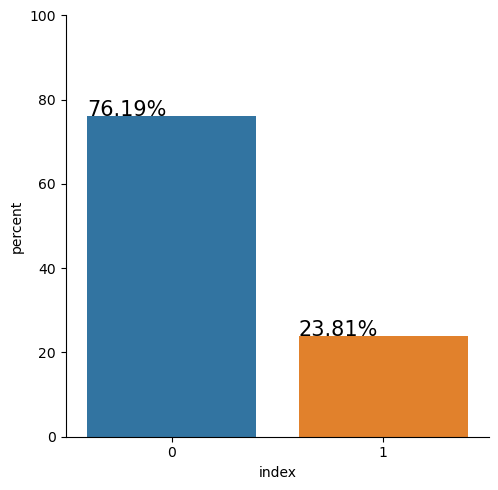

In [6]:
target_perc = df[target_name].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(data=target_perc, x='index', y='percent', kind='bar')
g.ax.set_ylim(0, 100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x, txt_y = p.get_x(), p.get_height()
    g.ax.text(x=txt_x, y=txt_y, s=txt, fontdict={'size': 15})

In [7]:
X = df[feature_names].to_numpy()
y = df[target_name].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=0)

In [8]:
preprocessor = ColumnTransformer([ 
                                  ("cat", OneHotEncoder(sparse=False, drop='if_binary',handle_unknown="ignore"),
                                   categorical_indices)],remainder='passthrough')

In [9]:
preprocessor = preprocessor.fit(X_train)

In [10]:
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [11]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
rf = rf.fit(X_train_ohe, y_train)

In [12]:
# evaluate classifier on train data
y_train_hat = rf.predict(X_train_ohe)
print(classification_report(y_true=y_train, y_pred=y_train_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [13]:
# evaluate classifier on test data
y_test_hat = rf.predict(X_test_ohe)
print(classification_report(y_true=y_test, y_pred=y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [30]:
def predict_fn(X: np.ndarray) -> np.ndarray:
    return rf.predict(preprocessor.transform(X))

In [31]:
explainer = PermutationImportance(predictor=predict_fn,
score_fns=['accuracy', 'f1'],
feature_names=feature_names,
verbose=True)

In [32]:
exp = explainer.explain(X=X_test, y=y_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.99s/it]


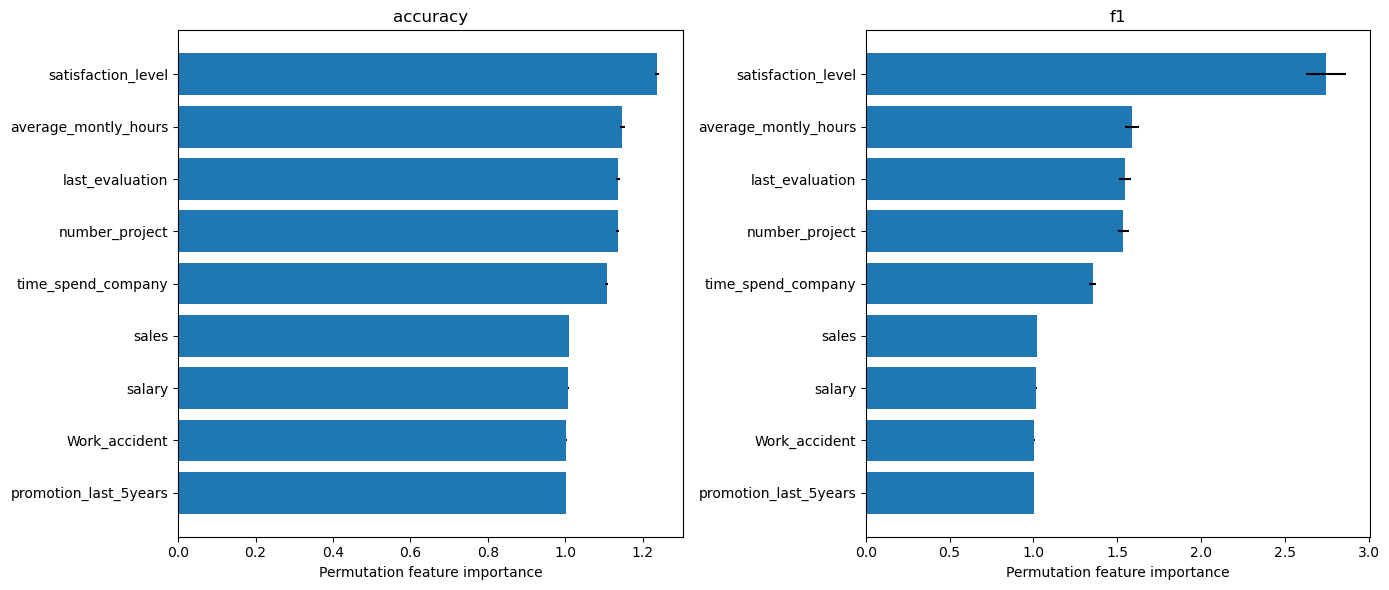

In [33]:
plot_permutation_importance(exp,
n_cols=2,
fig_kw={'figwidth': 14, 'figheight': 6});

In [40]:
 def loss_f1(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return 1 - f1_score(y_true=y_true, y_pred=y_pred)

In [41]:
explainer_loss_f1 = PermutationImportance(predictor=predict_fn,
loss_fns={'1 - f1': loss_f1},
feature_names=feature_names,
verbose=True)

In [42]:
exp_loss_f1 = explainer_loss_f1.explain(X=X_test, y=y_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.95s/it]


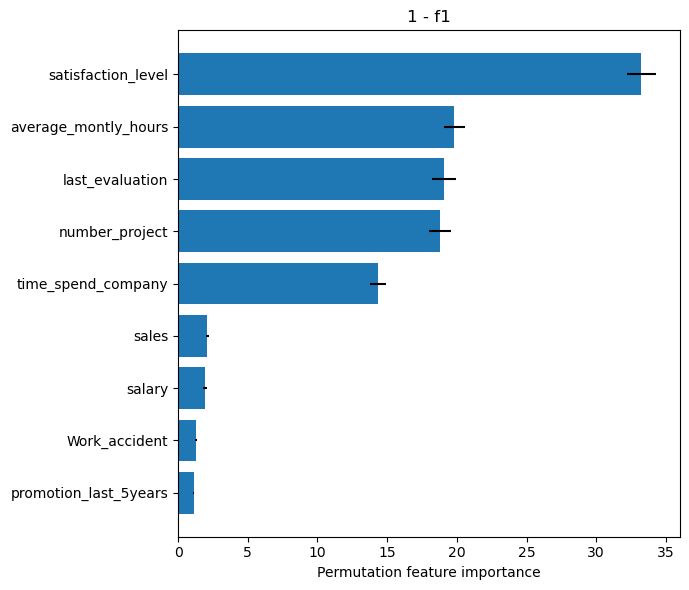

In [43]:
plot_permutation_importance(exp=exp_loss_f1,
fig_kw={'figwidth': 7, 'figheight': 6});

In [44]:
def loss_auc(y_true: np.ndarray, y_score: np.ndarray) -> float:
        return 1 - roc_auc_score(y_true=y_true, y_score=y_score)
def proba_fn(X: np.ndarray) -> np.ndarray:
    return rf.predict_proba(preprocessor.transform(X))[:, 1]

In [45]:
explainer_loss_auc = PermutationImportance(predictor=proba_fn,
loss_fns={'1 - auc': loss_auc},
feature_names=feature_names,
verbose=True)

In [46]:
exp_loss_auc = explainer_loss_auc.explain(X=X_test, y=y_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  3.00s/it]


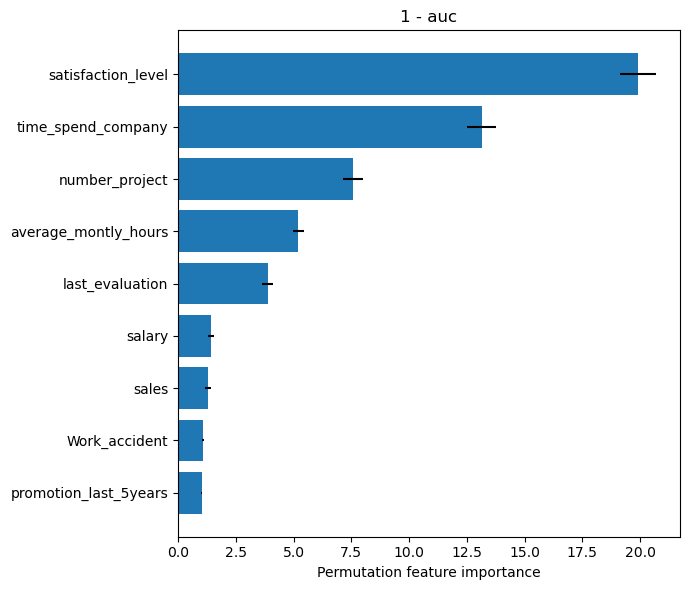

In [47]:
plot_permutation_importance(exp=exp_loss_auc,
fig_kw={'figwidth': 7, 'figheight': 6});